##### Find out if matrix D is following some random distribution or not

In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# sys.path.append('/Users/lennartredl/Desktop/MachineLearningProjects/TheisLab_Mubind/mubind')


In [7]:
# changing directory remove if another filesystem
cd /mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [8]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [9]:
model = model = model_by_logdynamic[1]

In [24]:
# evaluate_metric function, that compares the metric of the original matrix with the metric of the scrambled matrices

def metric_scramble_comparison(C,
                               D,
                               metric,
                               scramble_type,
                               n_scrambles=1000,
                               verbose=True):
    if C.is_sparse:
        C = C.to_dense()
    if D.is_sparse:
        D = D.to_dense()
    score_D = metric(C, D)
    scores_scrambled = []
    if scramble_type == "flat":
        # scrambling D - making sure that we get (n!)^2 different possible matrices instead of (n^2)!
        D_flat = D.flatten()
        scores_scrambled = [metric(C, D_flat[torch.randperm(496**2)].reshape(496, 496)) for _ in range(n_scrambles)]
    elif scramble_type == "row":
        scores_scrambled = [metric(C, D[torch.randperm(496), :]) for _ in range(n_scrambles)]
    elif scramble_type == "column":
        scores_scrambled = [metric(C, D[:, torch.randperm(496)]) for _ in range(n_scrambles)]
    else:
        raise ValueError("scramble_type must be one of 'flat', 'row', 'column'")
    scores_scrambled_df = pd.DataFrame(scores_scrambled, columns=['score'])
    if verbose:
        print(f"Summary statistics of the scores of scrambled matrices: \n{scores_scrambled_df.describe()} \n \n")
        print(f"This is the score of the original matrix: {score_D}")
    
    return scores_scrambled_df

In [11]:
# defining various scores, that can easily be interpreted 
def normalized_alignment_score(C, D):
    # Compute the element-wise product and then sum all elements
    numerator = torch.sum(C * D)
    # Compute the Frobenius norms of C and D
    norm_C = torch.norm(C, p='fro')
    norm_D = torch.norm(D, p='fro')
    # Compute the normalized alignment score
    score = numerator / (norm_C * norm_D)
    return score.item()

In [12]:
# for convenience
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# get the connectivity and weight matrix from the model
C = model.graph_module.conn_sparse
a_ind = C.indices()
D = model.graph_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape) 
D_triu = tspa(a_ind, -D, C.shape)  
D = D_tril + torch.transpose(D_triu, 0, 1)

In [27]:
scores_alignment_flat = metric_scramble_comparison(C, D, normalized_alignment_score, 'flat', verbose=0)
scores_alignment_row = metric_scramble_comparison(C, D, normalized_alignment_score, 'row', verbose=0)
scores_alignment_column = metric_scramble_comparison(C, D, normalized_alignment_score, 'column', verbose=0)
original_score = normalized_alignment_score(C, D)


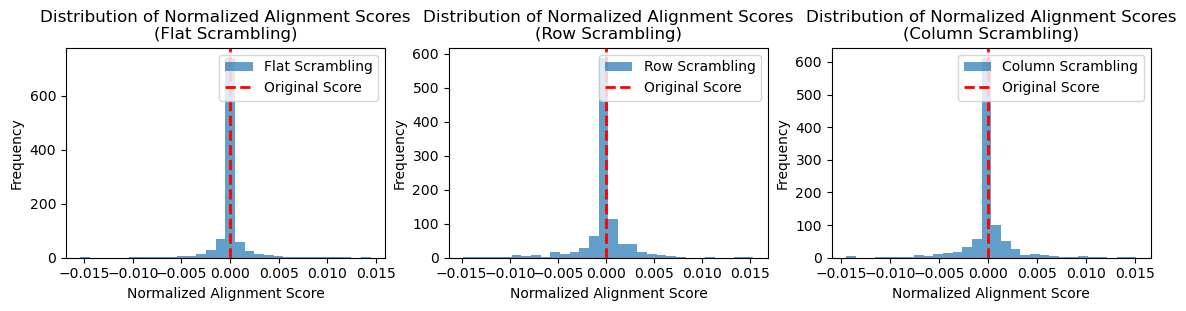

In [42]:
plt.figure(figsize=(14, 6))

# flat scrambling
plt.subplot(2, 3, 1)
plt.hist(scores_alignment_flat, bins=30, alpha=0.7, label='Flat Scrambling')
plt.axvline(original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\n(Flat Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()

# row scrambling
plt.subplot(2, 3, 2)
plt.hist(scores_alignment_row, bins=30, alpha=0.7, label='Row Scrambling')
plt.axvline(original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\n(Row Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()

# column scrambling
plt.subplot(2, 3, 3)
plt.hist(scores_alignment_column, bins=30, alpha=0.7, label='Column Scrambling')
plt.axvline(original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\n(Column Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()


In [43]:

positives_alignment_flat = metric_scramble_comparison(C, C, normalized_alignment_score, 'flat', verbose=0)
positives_alignment_row = metric_scramble_comparison(C, C, normalized_alignment_score, 'row', verbose=0)
positives_alignment_column = metric_scramble_comparison(C, C, normalized_alignment_score, 'column', verbose=0)
positives_original_score = normalized_alignment_score(C, C)

In [ ]:
# flat scrambling
plt.subplot(2, 3, 4)
plt.hist(positives_alignment_flat, bins=30, alpha=0.7, label='Flat Scrambling')
plt.axvline(positives_original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\nPositives - (Flat Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()

# row scrambling
plt.subplot(2, 3, 5)
plt.hist(positives_alignment_row, bins=30, alpha=0.7, label='Row Scrambling')
plt.axvline(positives_original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\nPositives - (Row Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()

# column scrambling
plt.subplot(2, 3, 6)
plt.hist(positives_alignment_column, bins=30, alpha=0.7, label='Column Scrambling')
plt.axvline(positives_original_score, color='r', linestyle='dashed', linewidth=2, label='Original Score')
plt.title('Distribution of Normalized Alignment Scores\nPositives - (Column Scrambling)')
plt.xlabel('Normalized Alignment Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

#### Understand the contribution of the filters

In [14]:
print(model.get_log_activities().shape)

torch.Size([1, 288, 496])


In [15]:
A = model.get_log_activities()
A = A.squeeze(0)
print(A.shape)
print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

torch.Size([288, 496])
Percentage of non-zero entries of the filter matrix A: 100.0 %


In [16]:
'''
We want to understand, how each filter contributes to the overall result together with C * D := H.

Since the i-th row of (A @ H), now denoted as (A @ H)_{i,:}, is nothing but (H.T @ A.T_{:,i}).T, (X_{:,i} is the i-th column of X) we want to compute the matrix vector product between H.T and the i-th column of A.T and find out how much it scales.
We'll later normalize this with the maximum absolute eigenvalue of H.
'''

def compute_contributions(A, H):
    """
    efficient implementation:
    contributions = torch.norm(H.T @ A.T, dim=0) / torch.norm(A.T, dim=0)
    """
    # this implementation for contributions is not efficient, but easier to interpret
    contributions = torch.zeros(A.T.shape[0]) # number of columns of A.T
    i = 0
    for column in torch.unbind(A.T, dim=1):
        contributions[i] = (torch.norm((H.T @ column)) / torch.norm(column)).item()
        i += 1
    max_eig = torch.max(torch.abs(torch.linalg.eigvals(H.to_dense()))).item()
    # sort the contributions by their absolute values descdendingly
    _, indices = torch.sort(contributions, descending=True)
    return indices, contributions, max_eig

In [30]:
indices, contributions, max_eig = compute_contributions(A, C * D)
contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



,index
count,496.000000
mean,0.333126
std,0.301472
min,0.000000
25%,0.000000
50%,0.408736
75%,0.601220
max,0.856258


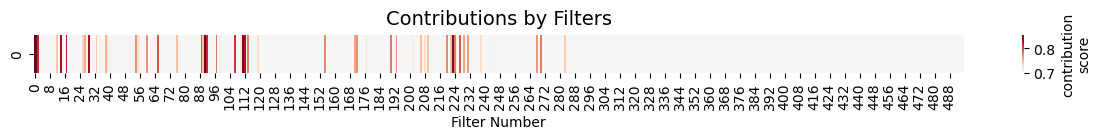

In [40]:
contributions_array = contributions_normalized.unsqueeze(dim=0).detach().numpy()

plt.figure(figsize=(15, .5))
# only visualize filters with contribution scores above 0.7
ax = sns.heatmap(contributions_array,
                 cmap='RdBu_r',
                 vmin=0.7,
                 center=0.7,
                 cbar_kws={"label": "contribution\nscore"})
ax.set_xlabel('Filter Number',
              fontsize=10)
ax.set_title('Contributions by Filters',
             fontsize=14,
             y=1.05)
plt.show()